# Biodata
**Name:** Rivo Raikhan Maulana  
**Student ID:** 1314623055  
**Program:** Statistika 2023 A  

**Repo:** [Sentiment Analysis – 2024 Presidential Campaign](https://github.com/Rivooooo/Sentiment-Analysis/blob/master/sentiment_analysis_2024_presidential_campaign/sentiment_analysis_2024_presidential_campaign.ipynb)


# Initialize

In [3]:
# Uncomment if running in Colab VM
# !git clone https://github.com/Rivooooo/Sentiment-Analysis.git

In [4]:
# Uncomment if running in Colab VM
# %cd Sentiment-Analysis/sentiment_analysis_2024_presidential_campaign

In [5]:
# !pip install -r requirements.txt

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import ast
import re


## Load Data


In [7]:
anies_df = pd.read_csv("dataset/cleaned data/Anies Baswedan.csv")
ganjar_df = pd.read_csv("dataset/cleaned data/Ganjar Pranowo.csv")
prabowo_df = pd.read_csv("dataset/cleaned data/Prabowo Subianto.csv")

## Data Exploration

In [8]:
anies_df = anies_df[['tweet_tokens_stemmed','label']]
ganjar_df = ganjar_df[['tweet_tokens_stemmed','label']]
prabowo_df = prabowo_df[['tweet_tokens_stemmed','label']]

In [9]:
# Display basic information about the datasets
def display_dataset_info(df, name):
    print(f"\n{'='*60}")
    print(f"Dataset: {name}")
    print(f"{'='*60}")
    print(f"Dataset Shape: {df.shape}")
    print(f"\nColumn Names: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    display(df.head())
    print(f"\nLabel Distribution:")
    print(df['label'].value_counts())
    print(f"\nLabel Distribution (Percentage):")
    print(df['label'].value_counts(normalize=True) * 100)

In [10]:
# Display info for all datasets
for df, name in [(anies_df, "Anies Baswedan"), (ganjar_df, "Ganjar Pranowo"), (prabowo_df, "Prabowo Subianto")]:
    display_dataset_info(df, name)


Dataset: Anies Baswedan
Dataset Shape: (8856, 2)

Column Names: ['tweet_tokens_stemmed', 'label']

First few rows:


,tweet_tokens_stemmed,label
0,"['anies', 'president', 'info']",Positive
1,"['gerindra', 'party', 'politician', 'sandiaga'...",Positive
2,"['mr', 'anies', 'continued', '', 'we', 'will',...",Positive
3,"['may', 'allah', 'swt', 'save', 'the', 'nation...",Positive
4,"['poor', 'chotimah', '', 'uncle', 'anies', '',...",Positive



Label Distribution:
label
Positive    5810
Negative    3043
Name: count, dtype: int64

Label Distribution (Percentage):
label
Positive    65.627471
Negative    34.372529
Name: proportion, dtype: float64

Dataset: Ganjar Pranowo
Dataset Shape: (7836, 2)

Column Names: ['tweet_tokens_stemmed', 'label']

First few rows:


,tweet_tokens_stemmed,label
0,"['ganjar', 'is', 'getting', 'more', 'and', 'mo...",Positive
1,"['ojoo', 'lali', 'yooo', 'who', 'is', 'smart',...",Positive
2,"['smart', 'people', 'support', 'and', 'reward'...",Positive
3,"['we', 'believe', 'that', 'pranowo', 's', 'rew...",Positive
4,"['intelligent', 'people', 'support', 'and', 'r...",Positive



Label Distribution:
label
Positive    6210
Negative    1626
Name: count, dtype: int64

Label Distribution (Percentage):
label
Positive    79.249617
Negative    20.750383
Name: proportion, dtype: float64

Dataset: Prabowo Subianto
Dataset Shape: (6757, 2)

Column Names: ['tweet_tokens_stemmed', 'label']

First few rows:


,tweet_tokens_stemmed,label
0,"['gemira', 'and', 'semeton', 'bal', 'muslims',...",Positive
1,"['fahnoor', 'inismyname', 'that', 's', 'why', ...",Negative
2,"['this', 'time', '', 'jokowi', 's', 'quota', '...",Positive
3,"['happy', 'birthday', 'to', 'kopassus', '', 'm...",Positive
4,"['gerindra', 'badung', 'party', 'held', 'legis...",Negative



Label Distribution:
label
Positive    5013
Negative    1744
Name: count, dtype: int64

Label Distribution (Percentage):
label
Positive    74.189729
Negative    25.810271
Name: proportion, dtype: float64


## Define Analyisis Pipeline function

In [11]:
# Modular Functions for Sentiment Analysis

def convert_tokens_to_text(token_list):
    """
    Convert a list of tokens back to a string for vectorization.
    
    Args:
        token_list: List of tokens or string representation of list
    
    Returns:
        String of space-separated tokens
    """
    if isinstance(token_list, str):
        # If it's a string, try to evaluate it as a list
        try:
            import ast
            token_list = ast.literal_eval(token_list)
        except:
            # If evaluation fails, split by spaces
            token_list = token_list.split()
    elif not isinstance(token_list, list):
        # If it's not a list, convert to string and split
        token_list = str(token_list).split()
    
    # Join tokens with spaces
    return ' '.join(token_list)

def preprocess_data(df, dataset_name):
    """
    Preprocess the dataset: handle missing labels and convert tokens to text.
    
    Args:
        df: DataFrame with 'tweet_tokens_stemmed' and 'label' columns
        dataset_name: Name of the dataset for logging
    
    Returns:
        Preprocessed DataFrame
    """
    print(f"\n{'='*60}")
    print(f"Preprocessing: {dataset_name}")
    print(f"{'='*60}")
    
    # Create a copy to avoid modifying original
    df_processed = df.copy()
    
    # Check for missing values in label column
    missing_labels = df_processed['label'].isna().sum()
    print(f"Missing labels found: {missing_labels}")
    
    # Drop rows with missing labels
    print(f"Before dropping missing labels: {len(df_processed)} rows")
    df_processed = df_processed.dropna(subset=['label'])
    print(f"After dropping missing labels: {len(df_processed)} rows")
    
    # Convert tokenized lists to text strings
    df_processed['text'] = df_processed['tweet_tokens_stemmed'].apply(convert_tokens_to_text)
    
    # Verify conversion
    print(f"Sample converted text: {df_processed['text'].iloc[0]}")
    
    return df_processed

def train_and_evaluate_models(df_processed, dataset_name, test_size=0.2, random_state=42):
    """
    Train SVM and Naive Bayes models and evaluate them.
    
    Args:
        df_processed: Preprocessed DataFrame
        dataset_name: Name of the dataset
        test_size: Proportion of data for testing
        random_state: Random state for reproducibility
    
    Returns:
        Dictionary containing models, predictions, metrics, and data splits
    """
    print(f"\n{'='*60}")
    print(f"Training Models: {dataset_name}")
    print(f"{'='*60}")
    
    # Prepare features and labels
    X = df_processed['text']
    y = df_processed['label']
    
    # Encode labels to numeric values (Positive=1, Negative=0)
    label_map = {'Positive': 1, 'Negative': 0}
    y_encoded = y.map(label_map)
    
    print(f"Total samples: {len(X)}")
    print(f"Label distribution:")
    print(f"  Positive: {sum(y_encoded == 1)}")
    print(f"  Negative: {sum(y_encoded == 0)}")
    
    # Convert text to TF-IDF features
    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),  # Include unigrams and bigrams
        min_df=2,
        max_df=0.95
    )
    
    X_vectorized = vectorizer.fit_transform(X)
    print(f"\nFeature matrix shape: {X_vectorized.shape}")
    print(f"Number of features: {X_vectorized.shape[1]}")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_vectorized, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    
    print(f"\nTraining samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    
    # Train SVM classifier
    print("\nTraining SVM classifier...")
    svm_classifier = SVC(kernel='linear', random_state=random_state, probability=True)
    svm_classifier.fit(X_train, y_train)
    svm_predictions = svm_classifier.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_predictions)
    
    # Train Naive Bayes classifier
    print("Training Naive Bayes classifier...")
    nb_classifier = MultinomialNB(alpha=1.0)
    nb_classifier.fit(X_train, y_train)
    nb_predictions = nb_classifier.predict(X_test)
    nb_accuracy = accuracy_score(y_test, nb_predictions)
    
    # Calculate F1 scores
    svm_f1_macro = f1_score(y_test, svm_predictions, average='macro')
    svm_f1_weighted = f1_score(y_test, svm_predictions, average='weighted')
    svm_f1_scores = f1_score(y_test, svm_predictions, average=None)
    
    nb_f1_macro = f1_score(y_test, nb_predictions, average='macro')
    nb_f1_weighted = f1_score(y_test, nb_predictions, average='weighted')
    nb_f1_scores = f1_score(y_test, nb_predictions, average=None)
    
    # Confusion matrices
    svm_cm = confusion_matrix(y_test, svm_predictions)
    nb_cm = confusion_matrix(y_test, nb_predictions)
    
    # Store results
    results = {
        'dataset_name': dataset_name,
        'vectorizer': vectorizer,
        'svm_model': svm_classifier,
        'nb_model': nb_classifier,
        'svm_predictions': svm_predictions,
        'nb_predictions': nb_predictions,
        'y_test': y_test,
        'svm_accuracy': svm_accuracy,
        'nb_accuracy': nb_accuracy,
        'svm_f1_macro': svm_f1_macro,
        'svm_f1_weighted': svm_f1_weighted,
        'svm_f1_negative': svm_f1_scores[0],
        'svm_f1_positive': svm_f1_scores[1],
        'nb_f1_macro': nb_f1_macro,
        'nb_f1_weighted': nb_f1_weighted,
        'nb_f1_negative': nb_f1_scores[0],
        'nb_f1_positive': nb_f1_scores[1],
        'svm_cm': svm_cm,
        'nb_cm': nb_cm
    }
    
    print(f"\nSVM Accuracy: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")
    print(f"Naive Bayes Accuracy: {nb_accuracy:.4f} ({nb_accuracy*100:.2f}%)")
    
    return results

In [12]:
# Apply preprocessing to all datasets
anies_processed = preprocess_data(anies_df, "Anies Baswedan")
ganjar_processed = preprocess_data(ganjar_df, "Ganjar Pranowo")
prabowo_processed = preprocess_data(prabowo_df, "Prabowo Subianto")



Preprocessing: Anies Baswedan
Missing labels found: 3
Before dropping missing labels: 8856 rows
After dropping missing labels: 8853 rows
Sample converted text: anies president info

Preprocessing: Ganjar Pranowo
Missing labels found: 0
Before dropping missing labels: 7836 rows
After dropping missing labels: 7836 rows
Sample converted text: ganjar is getting more and more support  now support is coming from the city of batu  malang  east java  they have declared themselves as supporters of the president of the republic of indonesia  not only coming from malang district but also from blitar and others 

Preprocessing: Prabowo Subianto
Missing labels found: 0
Before dropping missing labels: 6757 rows
After dropping missing labels: 6757 rows
Sample converted text: gemira and semeton bal muslims declare support for prabowo as president  news updates


# Model Training

In [13]:
# Train and evaluate models for all three datasets
anies_results = train_and_evaluate_models(anies_processed, "Anies Baswedan")
ganjar_results = train_and_evaluate_models(ganjar_processed, "Ganjar Pranowo")
prabowo_results = train_and_evaluate_models(prabowo_processed, "Prabowo Subianto")



Training Models: Anies Baswedan
Total samples: 8853
Label distribution:
  Positive: 5810
  Negative: 3043

Feature matrix shape: (8853, 5000)
Number of features: 5000

Training samples: 7082
Test samples: 1771

Training SVM classifier...
Training Naive Bayes classifier...

SVM Accuracy: 0.8289 (82.89%)
Naive Bayes Accuracy: 0.7459 (74.59%)

Training Models: Ganjar Pranowo
Total samples: 7836
Label distribution:
  Positive: 6210
  Negative: 1626

Feature matrix shape: (7836, 5000)
Number of features: 5000

Training samples: 6268
Test samples: 1568

Training SVM classifier...
Training Naive Bayes classifier...

SVM Accuracy: 0.8705 (87.05%)
Naive Bayes Accuracy: 0.8170 (81.70%)

Training Models: Prabowo Subianto
Total samples: 6757
Label distribution:
  Positive: 5013
  Negative: 1744

Feature matrix shape: (6757, 5000)
Number of features: 5000

Training samples: 5405
Test samples: 1352

Training SVM classifier...
Training Naive Bayes classifier...

SVM Accuracy: 0.8395 (83.95%)
Naive B

# Evaluation

## Define Evaluation Function

In [14]:
def print_detailed_results(results):
    """Print detailed classification reports and confusion matrices."""
    print(f"\n{'='*60}")
    print(f"Detailed Results: {results['dataset_name']}")
    print(f"{'='*60}")
    
    print(f"\nSVM Classification Report:")
    print(classification_report(results['y_test'], results['svm_predictions'], 
                              target_names=['Negative', 'Positive']))
    print(f"\nSVM Confusion Matrix:")
    print(results['svm_cm'])
    
    print(f"\nNaive Bayes Classification Report:")
    print(classification_report(results['y_test'], results['nb_predictions'], 
                              target_names=['Negative', 'Positive']))
    print(f"\nNaive Bayes Confusion Matrix:")
    print(results['nb_cm'])
    
    print(f"\nF1 Scores:")
    print(f"  SVM - Macro: {results['svm_f1_macro']:.4f}, Weighted: {results['svm_f1_weighted']:.4f}")
    print(f"  SVM - Negative: {results['svm_f1_negative']:.4f}, Positive: {results['svm_f1_positive']:.4f}")
    print(f"  NB  - Macro: {results['nb_f1_macro']:.4f}, Weighted: {results['nb_f1_weighted']:.4f}")
    print(f"  NB  - Negative: {results['nb_f1_negative']:.4f}, Positive: {results['nb_f1_positive']:.4f}")

def plot_confusion_matrices(results):
    """Plot confusion matrices for both models."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # SVM Confusion Matrix
    sns.heatmap(results['svm_cm'], annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[0].set_title(f"SVM - {results['dataset_name']}\nAccuracy: {results['svm_accuracy']:.4f}", 
                     fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=11)
    axes[0].set_xlabel('Predicted Label', fontsize=11)
    
    # Naive Bayes Confusion Matrix
    sns.heatmap(results['nb_cm'], annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[1].set_title(f"Naive Bayes - {results['dataset_name']}\nAccuracy: {results['nb_accuracy']:.4f}", 
                     fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=11)
    axes[1].set_xlabel('Predicted Label', fontsize=11)
    
    plt.tight_layout()
    plt.show()

def plot_accuracy_comparison(results):
    """Plot accuracy comparison bar chart."""
    fig, ax = plt.subplots(figsize=(8, 6))
    models = ['SVM', 'Naive Bayes']
    accuracies = [results['svm_accuracy'], results['nb_accuracy']]
    colors = ['#3498db', '#2ecc71']
    
    bars = ax.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'Sentiment Analysis Model Comparison - {results["dataset_name"]}', 
                fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}\n({acc*100:.2f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Evaluation (Metrics)

In [15]:
# Print detailed results for all datasets
for results in [anies_results, ganjar_results, prabowo_results]:
    print_detailed_results(results)


Detailed Results: Anies Baswedan

SVM Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.72      0.74       609
    Positive       0.86      0.89      0.87      1162

    accuracy                           0.83      1771
   macro avg       0.81      0.80      0.81      1771
weighted avg       0.83      0.83      0.83      1771


SVM Confusion Matrix:
[[ 439  170]
 [ 133 1029]]

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.40      0.52       609
    Positive       0.75      0.93      0.83      1162

    accuracy                           0.75      1771
   macro avg       0.74      0.66      0.67      1771
weighted avg       0.75      0.75      0.72      1771


Naive Bayes Confusion Matrix:
[[ 244  365]
 [  85 1077]]

F1 Scores:
  SVM - Macro: 0.8076, Weighted: 0.8276
  SVM - Negative: 0.7434, Positive: 0.8717
  NB  - Macro: 0.6737, Weighted: 0.7216
  NB 

## Evaluation Visualizations

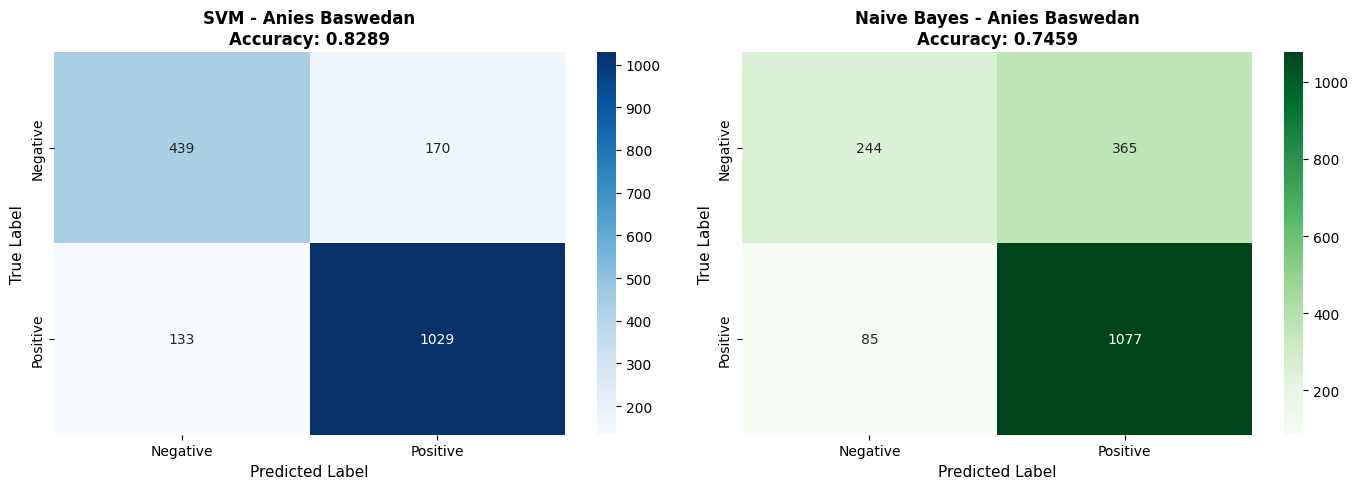

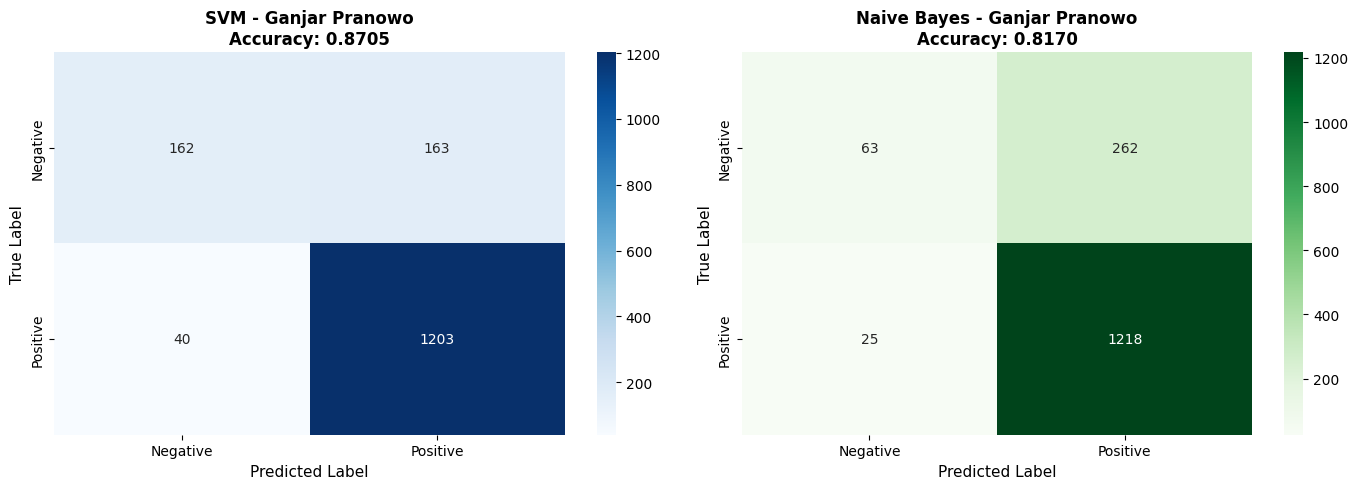

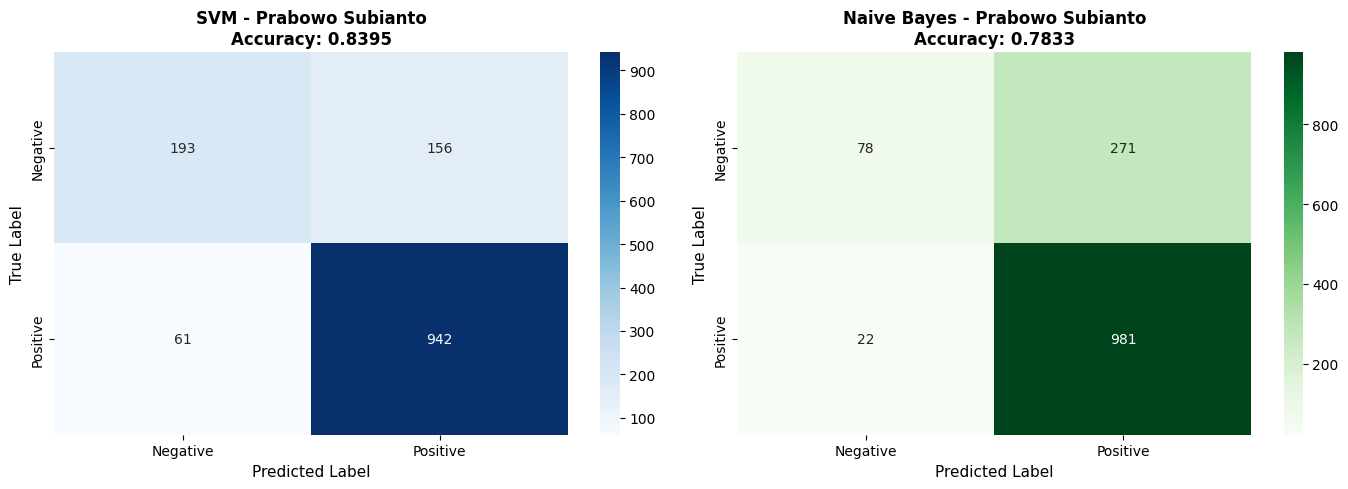

In [16]:
# Plot confusion matrices for all datasets
for results in [anies_results, ganjar_results, prabowo_results]:
    plot_confusion_matrices(results)


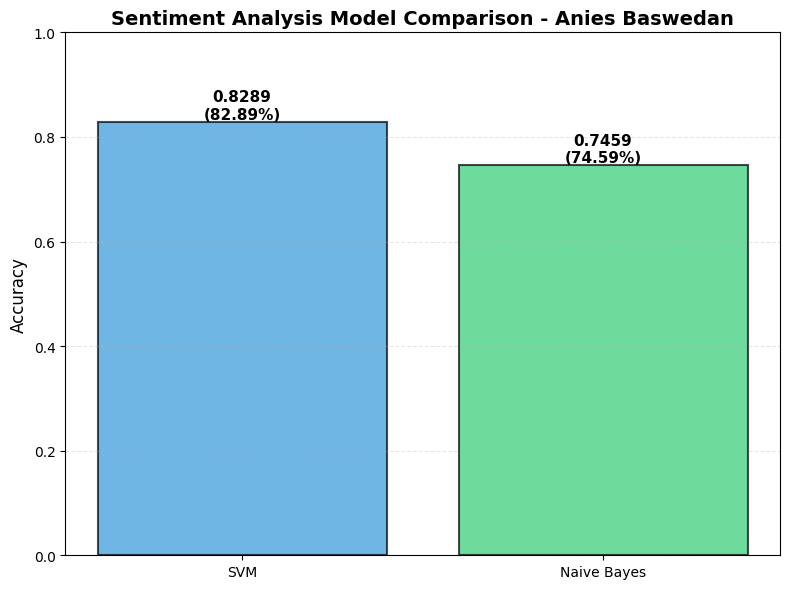

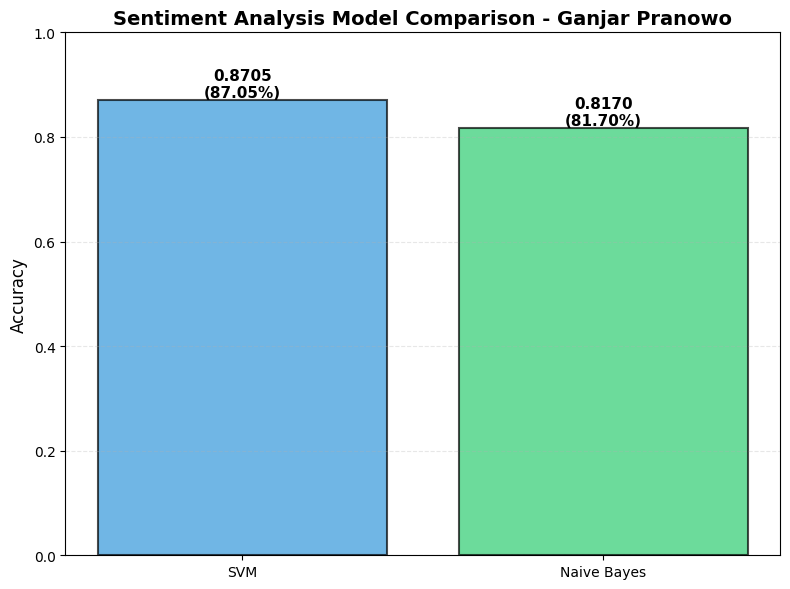

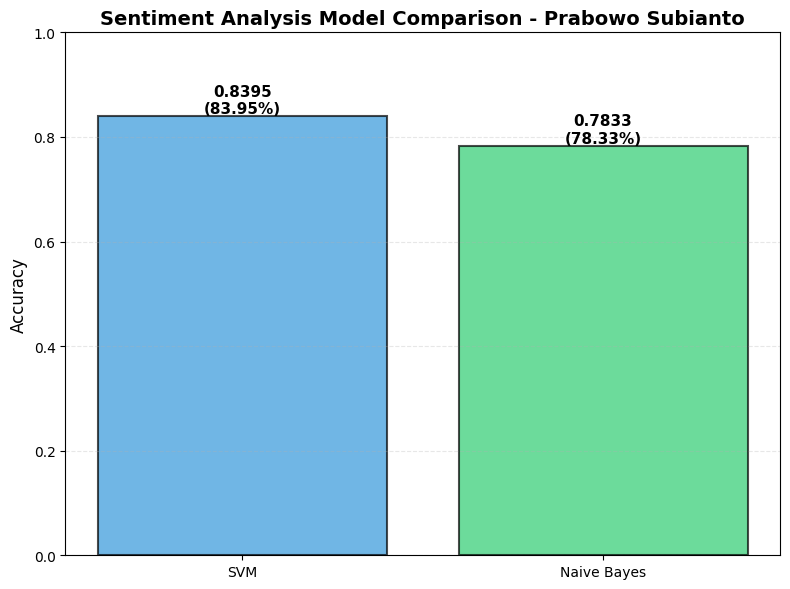

In [17]:
# Plot accuracy comparisons for all datasets
for results in [anies_results, ganjar_results, prabowo_results]:
    plot_accuracy_comparison(results)

## Define Cross-Dataset Comparison Function

In [18]:
def compare_all_datasets(results_list):
    """Compare results across all datasets."""
    print(f"\n{'='*80}")
    print("CROSS-DATASET COMPARISON")
    print(f"{'='*80}")
    
    # Create comparison DataFrame
    comparison_data = []
    for results in results_list:
        comparison_data.append({
            'Dataset': results['dataset_name'],
            'SVM Accuracy': results['svm_accuracy'],
            'NB Accuracy': results['nb_accuracy'],
            'SVM F1 Macro': results['svm_f1_macro'],
            'NB F1 Macro': results['nb_f1_macro'],
            'SVM F1 Weighted': results['svm_f1_weighted'],
            'NB F1 Weighted': results['nb_f1_weighted'],
            'Best Model': 'SVM' if results['svm_f1_macro'] > results['nb_f1_macro'] else 'Naive Bayes'
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\nModel Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    datasets = [r['dataset_name'] for r in results_list]
    x = np.arange(len(datasets))
    width = 0.35
    
    # Accuracy comparison
    svm_accs = [r['svm_accuracy'] for r in results_list]
    nb_accs = [r['nb_accuracy'] for r in results_list]
    axes[0, 0].bar(x - width/2, svm_accs, width, label='SVM', color='#3498db', alpha=0.7)
    axes[0, 0].bar(x + width/2, nb_accs, width, label='Naive Bayes', color='#2ecc71', alpha=0.7)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].set_title('Accuracy Comparison Across Datasets', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(datasets, rotation=15, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].set_ylim([0, 1])
    
    # F1 Macro comparison
    svm_f1_macro = [r['svm_f1_macro'] for r in results_list]
    nb_f1_macro = [r['nb_f1_macro'] for r in results_list]
    axes[0, 1].bar(x - width/2, svm_f1_macro, width, label='SVM', color='#3498db', alpha=0.7)
    axes[0, 1].bar(x + width/2, nb_f1_macro, width, label='Naive Bayes', color='#2ecc71', alpha=0.7)
    axes[0, 1].set_ylabel('F1 Score (Macro)', fontsize=12)
    axes[0, 1].set_title('F1 Macro Score Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(datasets, rotation=15, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].set_ylim([0, 1])
    
    # F1 Weighted comparison
    svm_f1_weighted = [r['svm_f1_weighted'] for r in results_list]
    nb_f1_weighted = [r['nb_f1_weighted'] for r in results_list]
    axes[1, 0].bar(x - width/2, svm_f1_weighted, width, label='SVM', color='#3498db', alpha=0.7)
    axes[1, 0].bar(x + width/2, nb_f1_weighted, width, label='Naive Bayes', color='#2ecc71', alpha=0.7)
    axes[1, 0].set_ylabel('F1 Score (Weighted)', fontsize=12)
    axes[1, 0].set_title('F1 Weighted Score Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(datasets, rotation=15, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].set_ylim([0, 1])
    
    # Best model summary
    best_models = [r['Best Model'] for r in comparison_data]
    model_counts = pd.Series(best_models).value_counts()
    axes[1, 1].bar(model_counts.index, model_counts.values, color=['#3498db', '#2ecc71'], alpha=0.7)
    axes[1, 1].set_ylabel('Number of Datasets', fontsize=12)
    axes[1, 1].set_title('Best Model by Dataset (Based on F1 Macro)', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df


## Comparison between 3 Candidate


CROSS-DATASET COMPARISON

Model Performance Comparison:
         Dataset  SVM Accuracy  NB Accuracy  SVM F1 Macro  NB F1 Macro  SVM F1 Weighted  NB F1 Weighted Best Model
  Anies Baswedan      0.828910     0.745906      0.807551     0.673722         0.827571        0.721643        SVM
  Ganjar Pranowo      0.870536     0.816964      0.768497     0.599843         0.858479        0.772412        SVM
Prabowo Subianto      0.839497     0.783284      0.768424     0.608753         0.830482        0.735157        SVM


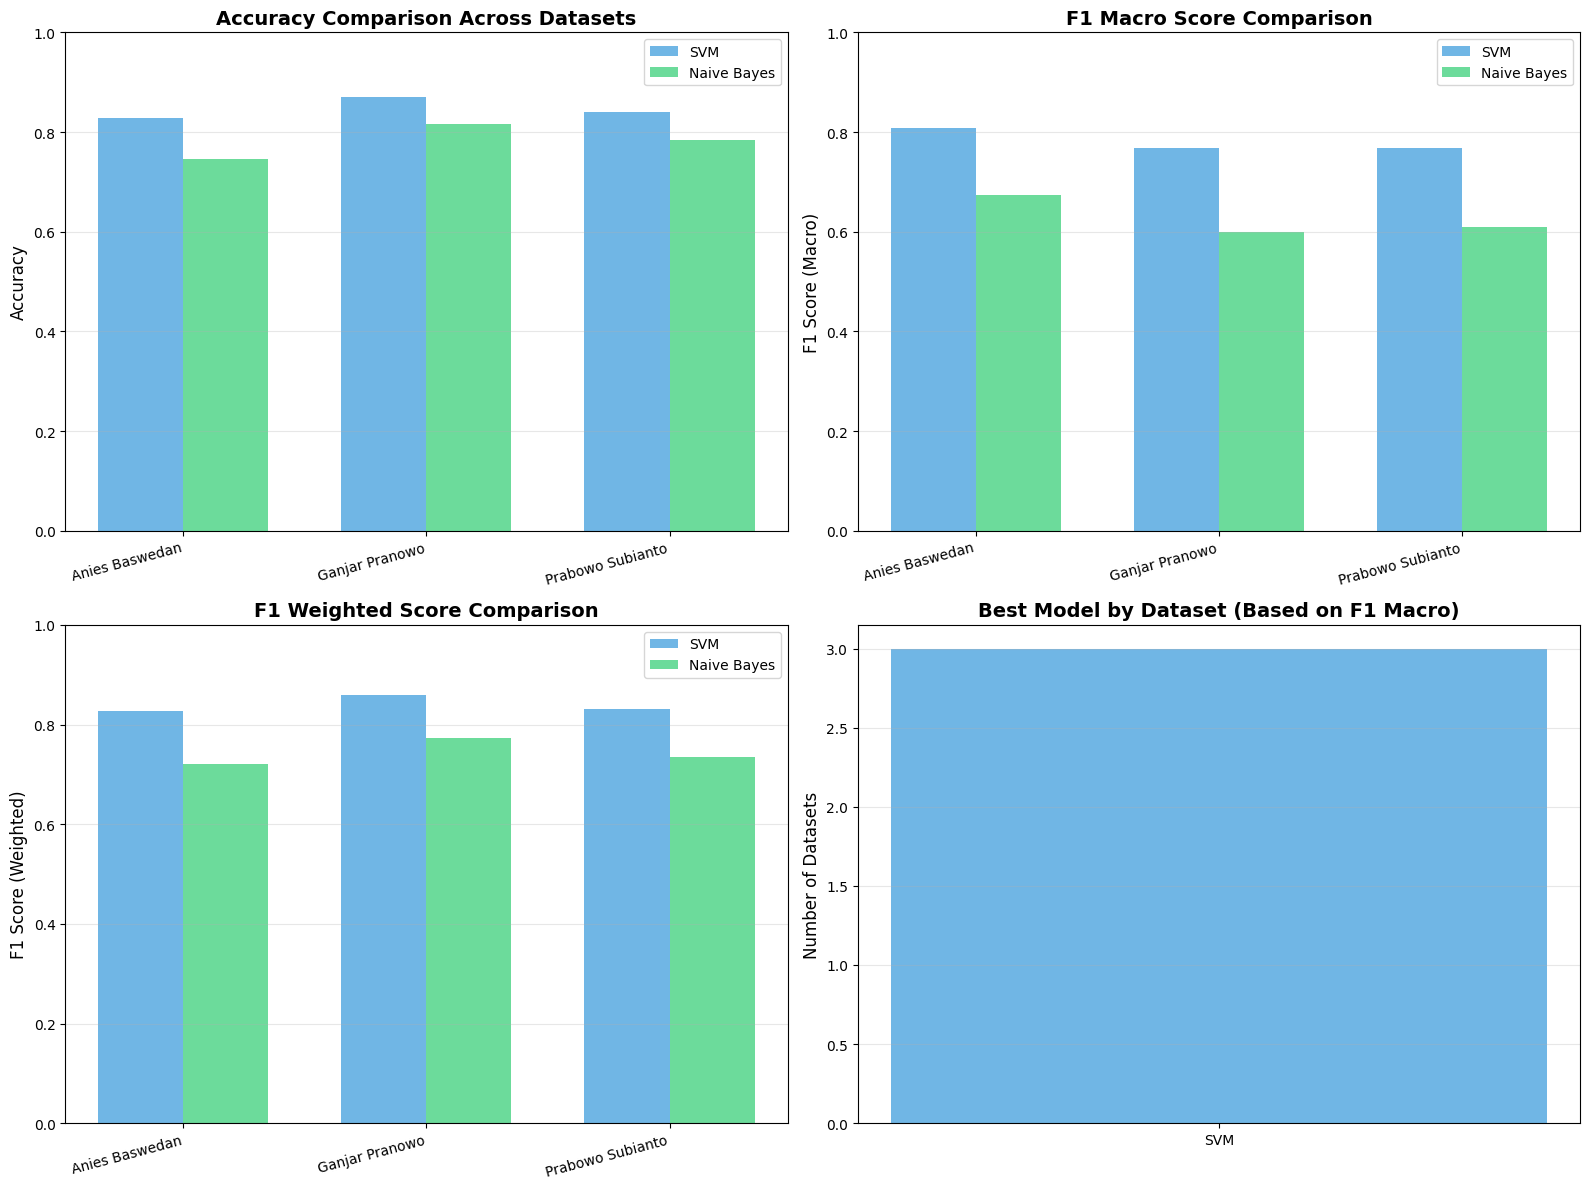

In [19]:
# Compare all datasets
comparison_df = compare_all_datasets([anies_results, ganjar_results, prabowo_results])

# WordCloud

In [20]:
# Stopwords List
custom_stopwords = {
    'anies', 'baswedan', 'ganjar', 'pranowo', 'prabowo', 'subianto', 
    'jokowi', 'president', 'presidential', 'candidate', 'election', 
    'republic', 'indonesia', 'mr', 's', 'will', 'become', 'support', 
    'continue', 'people','still', 'good', 'rt', 'gt', 'lt', 'say', 'reward', 'rewarded', 
    'time', 'make', 'one', 'info', 'get', 'must', 'know', 'let', 'really',
    'said', 'even', 'who', 'is','we', 'that', 'this', 'time', 'quota', 'happy',
    'birthday', 'to', 'held', 'held', 'campaign', 'indonesian', 'rasyid','country','gangar','n','t'
}

# Candidate list
candidates = [
    ("Anies Baswedan", anies_df),
    ("Ganjar Pranowo", ganjar_df),
    ("Prabowo Subianto", prabowo_df)
]

# Helper: join tokens, remove stopwords
def join_and_filter(tokens):
    tokens = eval(tokens) if isinstance(tokens, str) else tokens
    return " ".join([t for t in tokens if t not in custom_stopwords])

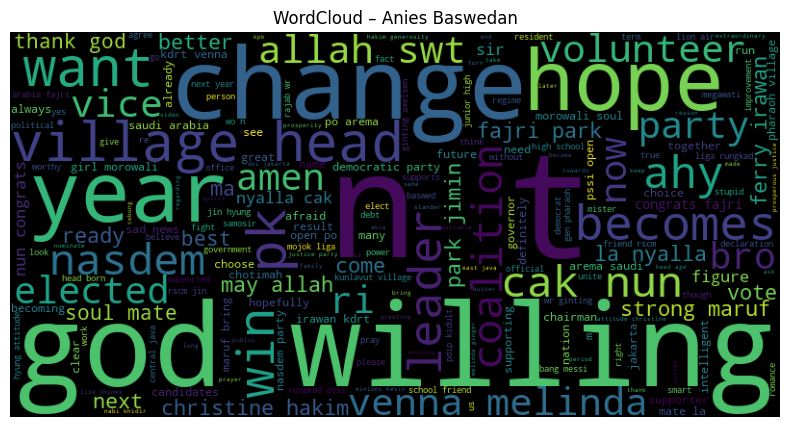

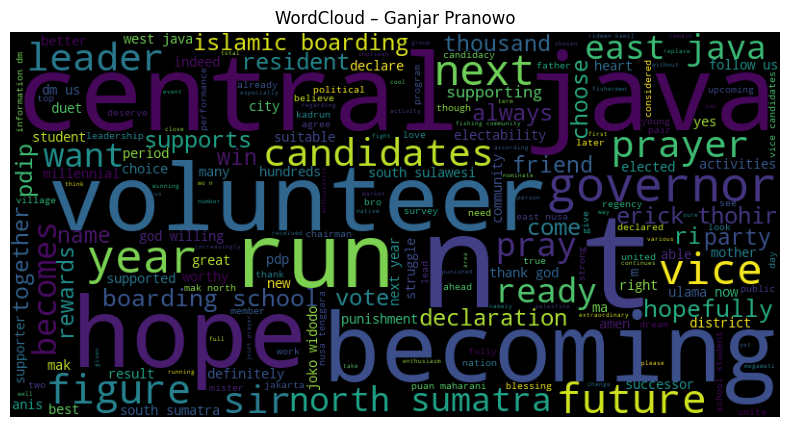

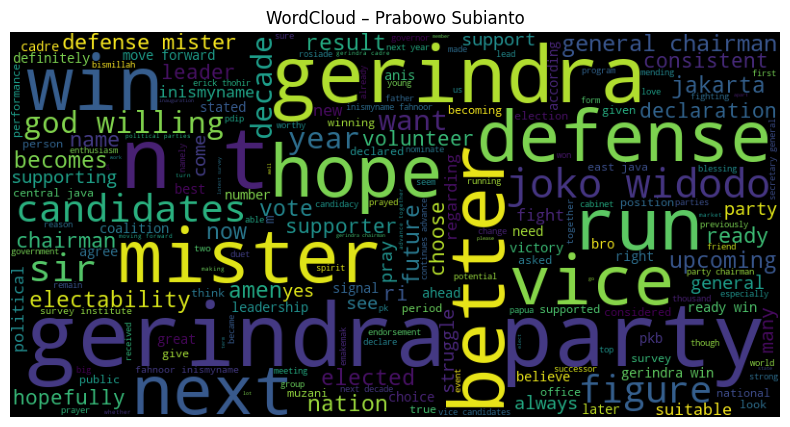

In [21]:
for name, df in candidates:
    text = df['tweet_tokens_stemmed'].apply(join_and_filter).str.cat(sep=" ")

    wc = WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"WordCloud – {name}")
    plt.show()


=== Anies Baswedan ===


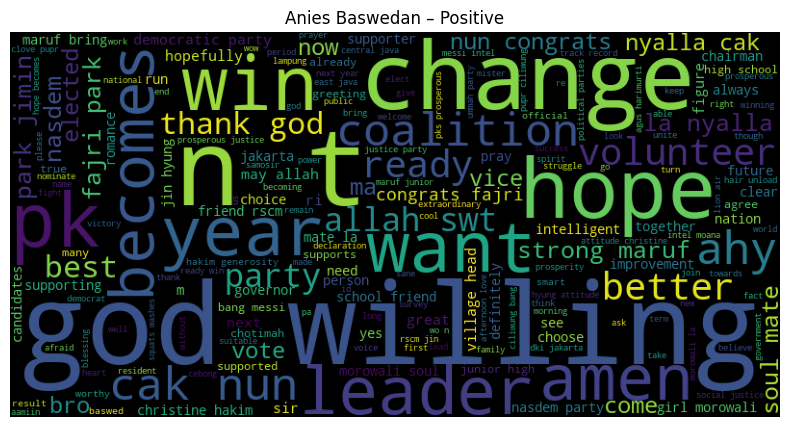

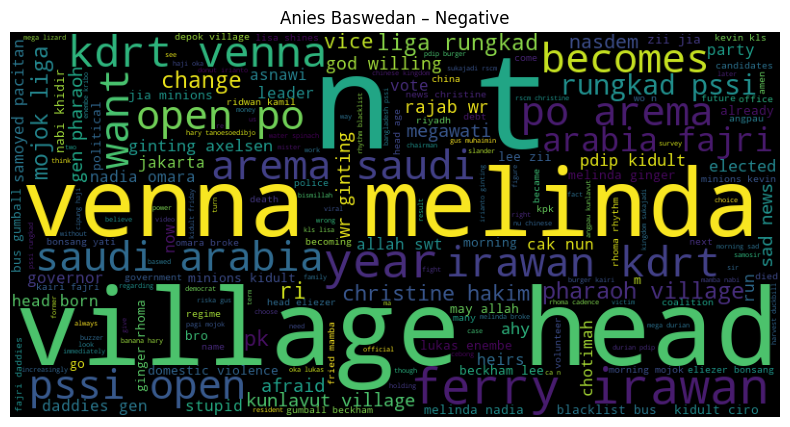

=== Ganjar Pranowo ===


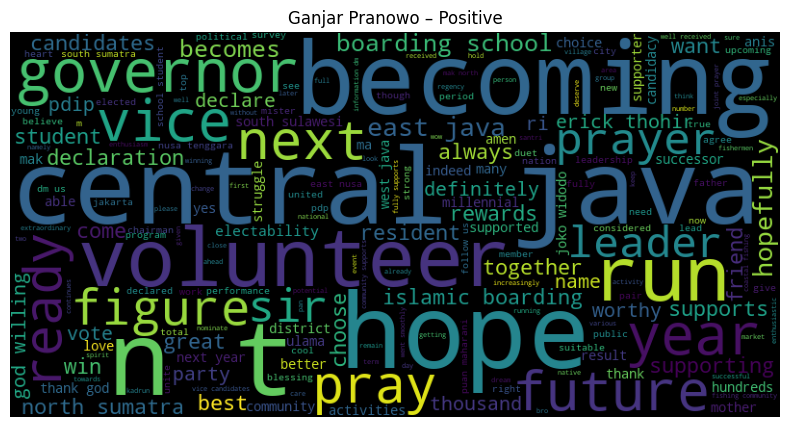

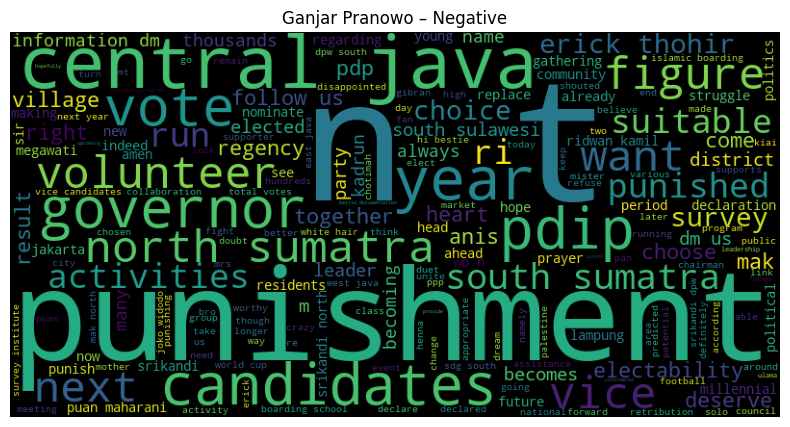

=== Prabowo Subianto ===


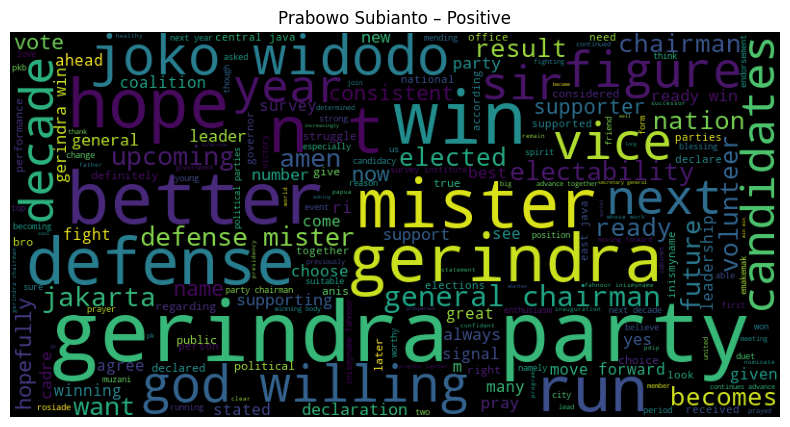

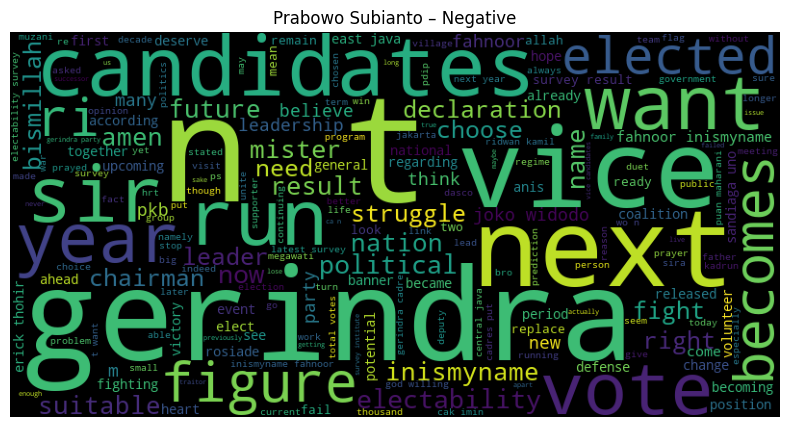

In [22]:
for name, df in candidates:

    print(f"=== {name} ===")

    for cls in df['label'].unique():
        subset = df[df['label'] == cls]

        if subset.empty:
            continue

        text = subset['tweet_tokens_stemmed'].apply(join_and_filter).str.cat(sep=" ")

        wc = WordCloud(width=800, height=400).generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc)
        plt.axis("off")
        plt.title(f"{name} – {cls}")
        plt.show()
